In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import PIL.Image as Image
import torchvision
import torch.nn as nn
import torch.optim as optim
import sys

In [2]:
sys.path.insert(0, '../src')
from bird_dataset import *
from XAI_birds_dataloader import *

In [3]:
bd = BirdDataset()

In [4]:
# class XAI_Birds_Dataset(Dataset):
    
#     def __init__(self, bd:BirdDataset, subset=True, transform=None, train=True):
#         self.bd = bd
#         self.transform = transform
#         self.subset = subset
#         self.train = train
#         if self.train: self.train_test_indices = self.bd.train_indices
#         else: self.train_test_indices = self.bd.test_indices
        
#         if self.subset: self.class_dict = self._set_classes('classes-subset')
#         else: self.class_dict = self._set_classes('classes')
#         self.images = self.load_images()
        
        
#     def __len__(self):
#         return len(self.images)
        
#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
#         img_id = list(self.images.keys())[idx]
#         img_path = os.path.join(self.bd.img_dir, self.images[img_id]['filepath'])
#         image = Image.open(img_path)
#         label = self.class_dict[self.images[img_id]['class_label']]
#         sample = {'image': image, 'label':label}
        
#         if self.transform:
#             sample['image'] = self.transform(sample['image'])
#         return sample
#     def _set_classes(self, fname):
#         with open(f'../CUB_200_2011/{fname}.txt') as f:
#             class_dict = {int(line.split(' ')[0]):i for i, line in enumerate(f.readlines())}
#         return class_dict
    
#     def load_images(self):
#         images = {}
#         for key in self.bd.images:
#             class_label = self.bd.images[key]['class_label']
#             if class_label in list(self.class_dict.keys()) and class_label in self.train_test_indices:
#                 images[key] = self.bd.images[key] 
#         return images

In [5]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_bird_dataset = XAI_Birds_Dataset(bd, transform=trans, train=True)
val_bird_dataset = XAI_Birds_Dataset(bd, transform=trans, train=False, val=True)

In [6]:
val_bird_dataset[1]

{'image': tensor([[[0.5373, 0.5451, 0.5569,  ..., 0.6157, 0.5490, 0.5412],
          [0.5412, 0.5490, 0.5608,  ..., 0.4980, 0.5333, 0.5373],
          [0.5373, 0.5490, 0.5608,  ..., 0.4667, 0.5490, 0.5451],
          ...,
          [0.7490, 0.7529, 0.7490,  ..., 0.7569, 0.5843, 0.3922],
          [0.7529, 0.7569, 0.7529,  ..., 0.7529, 0.5608, 0.3804],
          [0.7529, 0.7608, 0.7608,  ..., 0.7451, 0.5490, 0.3765]],
 
         [[0.6000, 0.5961, 0.5922,  ..., 0.5765, 0.5216, 0.4784],
          [0.6078, 0.6000, 0.5961,  ..., 0.4667, 0.5176, 0.4667],
          [0.6039, 0.6000, 0.5961,  ..., 0.4431, 0.5451, 0.4667],
          ...,
          [0.6941, 0.7020, 0.7020,  ..., 0.7176, 0.5569, 0.3882],
          [0.7020, 0.7059, 0.7059,  ..., 0.7176, 0.5490, 0.3804],
          [0.7020, 0.7098, 0.7098,  ..., 0.7098, 0.5333, 0.3804]],
 
         [[0.6784, 0.6706, 0.6667,  ..., 0.5333, 0.5255, 0.4196],
          [0.6824, 0.6745, 0.6667,  ..., 0.4392, 0.5294, 0.4039],
          [0.6824, 0.6706, 0.67

In [7]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_bird_dataset = XAI_Birds_Dataset(bd, transform=trans, train=True)
val_bird_dataset = XAI_Birds_Dataset(bd, transform=trans, train=False, val=True)

model = models.vgg16_bn(pretrained=False)
num_feats = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_feats, len(train_bird_dataset.class_dict))])
model.classifier = nn.Sequential(*features) # Replace the model classifier

In [8]:
model.load_state_dict(torch.load('../models/transfer_vgg16_31_class_5_epoch_4_batch.pth'))

<All keys matched successfully>

In [9]:
model.eval();
# # batch_size = 4
# trainloader = DataLoader(train_bird_dataset)
# valloader = DataLoader(val_bird_dataset)

In [10]:
# batch_size = 4
trainloader = DataLoader(train_bird_dataset)
valloader = DataLoader(val_bird_dataset)

In [10]:


# The function to show an image.
def imshow(img):
#     img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



In [11]:
# dataiter.next()

In [12]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.
if torch.cuda.is_available():
    model.cuda()

cuda:0


In [13]:
# if torch.cuda.is_available():
#     model.cuda()

In [14]:
class_dict = val_bird_dataset.class_dict
inv_classes = {v: k for k, v in class_dict.items()}

In [15]:
inv_classes = {v: k for k, v in class_dict.items()}

In [16]:
# labels

In [17]:
def topk_accuracy(k, labels, outputs):
    num_correct = 0
    _, predicted = outputs.topk(5, -1, largest=True, sorted=True)
    for idx, pred in enumerate(predicted):
#         print(labels[idx])
#         print(pred)
        if int(labels[idx]) in np.array(pred.cpu()): 
            num_correct += 1
    return num_correct

In [18]:
%%time
num_correct = 0
num_correct_k = 0
k = 5
# Check several images.
dataiter = iter(valloader)
batch_size = 1
for i in range(len(dataiter)):
    sample = dataiter.next()
    images, labels = sample['image'], sample['label']    
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)
    #     print(predicted)
    # print(labels)
    # print(predicted)
    num_correct_k += topk_accuracy(k, labels, outputs)
    num_correct += sum(np.array(labels)==np.array(predicted.cpu()))
    if i % 200 == 0:
        print("iteration",i)

iteration 0
iteration 200
iteration 400
iteration 600
iteration 800
iteration 1000
iteration 1200
iteration 1400
iteration 1600
iteration 1800
CPU times: user 34min 48s, sys: 10.4 s, total: 34min 59s
Wall time: 4min 43s


In [19]:
len(trainloader)

1466

In [20]:
print("Validation Accuracy:", num_correct / (len(valloader) * batch_size))
print(f"Top {k} Accuracy:", num_correct_k / (len(valloader) * batch_size))

Validation Accuracy: 0.9427168576104746
Top 5 Accuracy: 0.9950900163666121


In [37]:
print("Validation Accuracy:", num_correct / (len(valloader) * batch_size))
print(f"Top {k} Accuracy:", num_correct_k / (len(valloader) * batch_size))

Validation Accuracy: 0.9803921568627451
Top 5 Accuracy: 0.9971988795518207


In [22]:
bd.images

{1: {'filepath': '001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg',
  'class_label': 1,
  'bounding_box': [60.0, 27.0, 325.0, 304.0],
  'parts': {'beak': [312.0, 182.0],
   'crown': [186.0, 45.0],
   'forehead': [247.0, 79.0],
   'nape': [100.0, 221.0],
   'right eye': [183.0, 101.0],
   'throat': [215.0, 194.0]},
  'attributes': ['has_bill_shape::hooked_seabird',
   'has_head_pattern::masked',
   'has_throat_color::buff',
   'has_eye_color::brown',
   'has_bill_length::longer_than_head',
   'has_forehead_color::white',
   'has_nape_color::buff',
   'has_size::large_(16_-_32_in)',
   'has_shape::long-legged-like',
   'has_primary_color::buff',
   'has_bill_color::buff',
   'has_crown_color::buff']},
 2: {'filepath': '001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg',
  'class_label': 1,
  'bounding_box': [139.0, 30.0, 153.0, 264.0],
  'parts': {'back': [228.0, 138.0],
   'beak': [282.0, 154.0],
   'breast': [248.0, 158.0],
   'crown': [266.0, 141.0],
   'fore

In [21]:
class_dict

{10: 0,
 11: 1,
 12: 2,
 14: 3,
 15: 4,
 16: 5,
 17: 6,
 36: 7,
 37: 8,
 38: 9,
 39: 10,
 40: 11,
 41: 12,
 42: 13,
 43: 14,
 54: 15,
 55: 16,
 56: 17,
 57: 18,
 95: 19,
 96: 20,
 97: 21,
 98: 22,
 139: 23,
 140: 24,
 187: 25,
 188: 26,
 189: 27,
 190: 28,
 191: 29,
 192: 30}

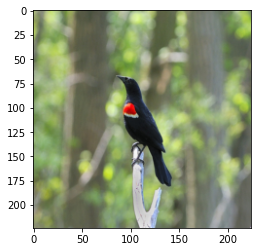

Ground Truth: [10]
Predicted: [10]
Accuracy: 1.0


In [37]:
# Check several images.
dataiter = iter(valloader)
batch_size = 1
# for i in range(len(dataiter)):
sample = dataiter.next()
images, labels = sample['image'], sample['label']
imshow(torchvision.utils.make_grid(images))
# print(labels)
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print("Ground Truth:", [inv_classes[int(labels[i])] for i in range(batch_size)])
print("Predicted:",[inv_classes[int(predicted[i])] for i in range(batch_size)])
print("Accuracy:",sum(np.array(labels)==np.array(predicted.cpu()))/len(labels))

**Captum Model Explainability**

In [22]:
from captum.attr import GuidedGradCam

# https://gilberttanner.com/blog/interpreting-pytorch-models-with-captum

In [23]:
last_conv = model.features[40]
gc = GuidedGradCam(model, last_conv)
samp = iter(valloader).next()
img, label = samp['image'].cuda(), samp['label'].cuda()
# img, label =  val_bird_dataset[0]['image'], val_bird_dataset[0]['label']
# for feat in model.features[:40]:
#     img = feat(img)

In [24]:
gc_img = gc.attribute(img, label)

/home/jdlevy/.local/lib/python3.7/site-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/jdlevy/.local/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


In [25]:
import cv2
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

In [26]:
plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [29]:
os.mkdir('../figures')

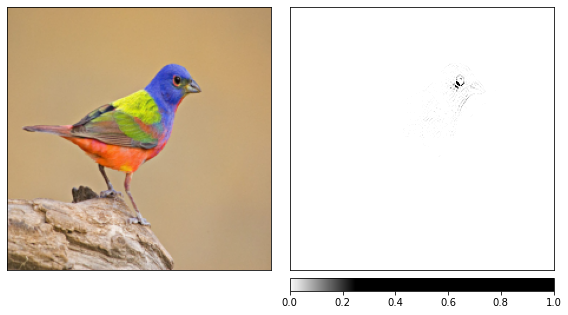

In [36]:
# create custom colormap for visualizing the result
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


# visualize the results using the visualize_image_attr helper method
x = viz.visualize_image_attr_multiple(np.transpose(gc_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap=default_cmap,
                             show_colorbar=True)
x[0].savefig('../figures/grad_cam_ex1.png', dpi=1800)

In [33]:
x

(<Figure size 576x432 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fc1a912d0>,
       dtype=object))

In [ ]:
# show some more examples...

In [85]:
sum(gc_img.cpu().detach().numpy()[0][0])

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


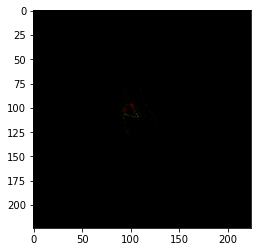

In [66]:
imshow(torchvision.utils.make_grid(gc_img.cpu().detach()))


In [53]:
gc?

In [57]:
last_conv

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [56]:
img.size()

torch.Size([1, 512, 14, 14])